In [1]:
# 1. DATA ACQUISITION & PREPROCESSING
from src.db import attach_duckdb, duckdb_to_df, load_sql

attach_duckdb("remote_mimic")
df = duckdb_to_df(load_sql("rev-cohort.sql"))
print(f"Initial Data: {len(df)} rows.\nDataFrame Columns: {len(df.columns)}")

DuckDB attached to remote PostgreSQL successfully.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Initial Data: 17017 rows.
DataFrame Columns: 32


In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import torch

# --- Step A: Define Feature Groups ---
# Continuous features need scaling + median imputation
continuous_cols = ['anchor_age', 'hematocrit', 'hemoglobin', 'wbc',
                   'platelet', 'creatinine', 'bun', 'ck_mb', 'trop_t', 'probnp']
# Score/Binary features need 0 imputation
score_cols = ['charlson_comorbidity_index', 'myocardial_infarct', 'congestive_heart_failure',
              'peripheral_vascular_disease','cerebrovascular_disease', 'dementia',
              'chronic_pulmonary_disease', 'rheumatic_disease', 'peptic_ulcer_disease',
              'mild_liver_disease', 'diabetes_without_cc', 'diabetes_with_cc', 'paraplegia',
              'renal_disease', 'malignant_cancer', 'severe_liver_disease', 'metastatic_solid_tumor',
              'prev_mi', 'stroke_history']

print(f"Missing data from 'continuous' features:\n{df[continuous_cols].isnull().sum()}")
print(f"Missing data from 'binary' features:\n{df[score_cols].isnull().sum()}")

Missing data from 'continuous' features:
anchor_age        0
hematocrit     4976
hemoglobin     5021
wbc            5020
platelet       5012
creatinine     4985
bun            4982
ck_mb          9179
trop_t         9930
probnp        15926
dtype: int64
Missing data from 'binary' features:
charlson_comorbidity_index     0
myocardial_infarct             0
congestive_heart_failure       0
peripheral_vascular_disease    0
cerebrovascular_disease        0
dementia                       0
chronic_pulmonary_disease      0
rheumatic_disease              0
peptic_ulcer_disease           0
mild_liver_disease             0
diabetes_without_cc            0
diabetes_with_cc               0
paraplegia                     0
renal_disease                  0
malignant_cancer               0
severe_liver_disease           0
metastatic_solid_tumor         0
prev_mi                        0
stroke_history                 0
dtype: int64


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import torch

# --- Step B: Handle Missing Values (The "Dual Strategy") ---
# 1. Impute Continuous with MEDIAN
imputer = SimpleImputer(strategy='median')
df[continuous_cols] = imputer.fit_transform(df[continuous_cols])

# 2. Impute Scores with ZERO (Assume NULL = Absence of condition)
df[score_cols] = df[score_cols].fillna(0)

# --- Step C: Encoding ---
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])

# Combine all features
feature_cols = continuous_cols + score_cols + ['gender']
X = df[feature_cols].values
y = df['label'].values

# --- Step D: Stratified Splitting ---
# Stratify=y ensures we have the same % of mortality in Train, Val, and Test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# --- Step E: Scaling (Standardization) ---
# CRITICAL: Fit scaler ONLY on X_train to prevent info leakage from Test set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()
pos_weight_value = num_neg / num_pos

print("-" * 30)
print(f"Train Shape: {X_train.shape}")
print(f"Class Balance (Train): {num_neg} Survivors vs {num_pos} Deaths")
print(f"Calculated pos_weight: {pos_weight_value:.4f}")
print("-" * 30)

17017
19
------------------------------
Train Shape: (11911, 30)
Class Balance (Train): 11374 Survivors vs 537 Deaths
Calculated pos_weight: 21.1806
------------------------------


In [72]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
import torch.nn as nn

class MortalityPredictor(nn.Module):
    def __init__(self, input_dim):
        super(MortalityPredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1) # Note: Logits output for BCEWithLogitsLoss
        )

    def forward(self, x):
        return self.network(x)
    
def train_and_calibrate(X_train, y_train, X_val, y_val, feature_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Prepare Tensors
    train_ds = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train).unsqueeze(1))
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    
    # Address Class Imbalance
    pos_weight = torch.tensor([(y_train == 0).sum() / (y_train == 1).sum()]).to(device)
    
    model = MortalityPredictor(X_train.shape[1]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # --- Training Loop ---
    model.train()
    for epoch in range(20):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(inputs), labels)
            loss.backward()
            optimizer.step()

            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Features: {inputs.shape[1]}", end='\r')

    # --- Step 1: Calibration (Fixing the Probability "Over-confidence") ---
    model.eval()
    with torch.no_grad():
        val_logits = model(torch.FloatTensor(X_val).to(device))
        val_probs_raw = torch.sigmoid(val_logits).cpu().numpy().flatten()
    
    # Fit Isotonic Regression on 1D arrays
    iso_reg = IsotonicRegression(out_of_bounds='clip')
    iso_reg.fit(val_probs_raw, y_val.flatten())
    
    print(f"Calibration Complete. Brier Score: {brier_score_loss(y_val, iso_reg.transform(val_probs_raw)):.4f}")
    print()
    return model, iso_reg

model, iso_reg = train_and_calibrate(X_train, y_train, X_val, y_val, feature_cols)

Calibration Complete. Brier Score: 0.0215



In [74]:
import joblib

print("Saving artifacts...")
torch.save(model.state_dict(), 'models/mortality_model.pth')
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(iso_reg, 'models/calibrator.pkl')

sample = X_test[1186:1187]
print(sample)

Saving artifacts...
[[-1.27449022e+00 -6.52336808e-03 -1.99576108e-02 -2.18771258e-01
  -1.66235325e-01 -2.51382288e-01 -2.80551850e-01  7.31031909e+00
   7.26508014e-01 -9.48505515e-02 -1.22282950e+00  1.09509110e+00
  -8.62510212e-01 -4.73048398e-01 -3.87641035e-01 -9.38527253e-02
  -5.54235824e-01 -2.00200738e-01 -1.11398787e-01 -2.47975494e-01
  -6.40510245e-01 -4.30729635e-01 -1.40010027e-01 -5.71953599e-01
  -1.91888068e-01 -7.52121844e-02 -6.93433736e-02 -2.98421681e-01
  -1.67749325e-01  6.62082212e-01]]


In [ ]:
import torch
import numpy as np
import joblib
import shap
from src.model_defs import MortalityPredictor


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
# 1. Load Artifacts
# Make sure to provide the correct path to your files
input_dim = sample.shape[1]
model = MortalityPredictor(input_dim).to(device)
model.load_state_dict(torch.load('models/mortality_model.pth'))
model.eval()
    
scaler = joblib.load('models/scaler.pkl')
calibrator = joblib.load('models/calibrator.pkl')

    # 2. Run Inference
with torch.no_grad():
    # Transform input
    X_scaled = scaler.transform(sample)
    X_tensor = torch.FloatTensor(X_scaled).to(device)
        
    # Get Model Logit -> Raw Probability
    logit = model(X_tensor)
    raw_prob = torch.sigmoid(logit).flatten()
        
    # Apply Isotonic Calibration
    calibrated_risk = calibrator.transform(raw_prob)

print(f"--- Inference Verification ---")
print(f"Raw Model Output (Sigmoid): {raw_prob[0]:.4f}")
print(f"Calibrated Mortality Risk: {calibrated_risk[0]:.2%}")
print(f"------------------------------")

--- Inference Verification ---
Raw Model Output (Sigmoid): 0.0016
Calibrated Mortality Risk: 0.00%
------------------------------


Optimal Threshold (Max F1): 0.8613

--- Clinical Performance Report (at Optimal Threshold) ---
              precision    recall  f1-score   support

    Survivor       0.98      0.99      0.99      2438
   Mortality       0.79      0.64      0.71       115

    accuracy                           0.98      2553
   macro avg       0.89      0.82      0.85      2553
weighted avg       0.97      0.98      0.97      2553



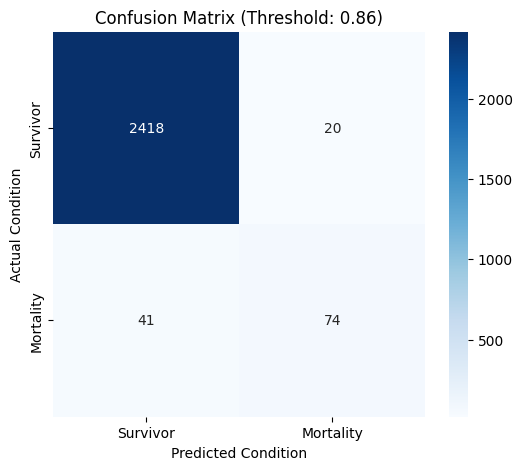


Brier Score (Calibration Error): 0.0749


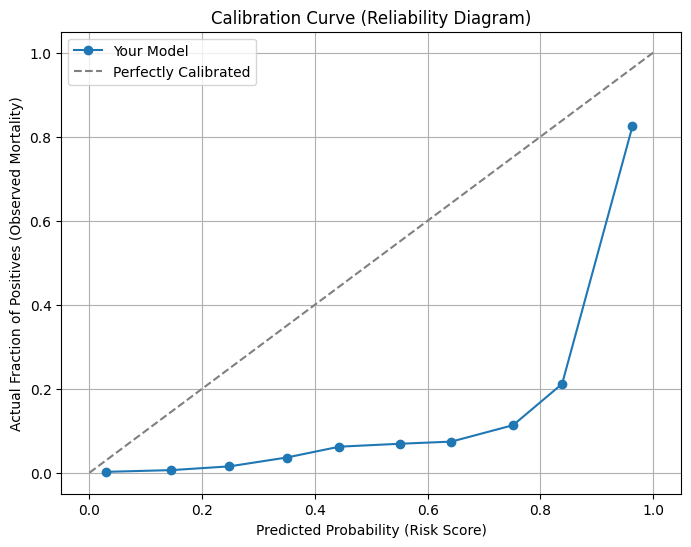

Sensitivity (Recall - Catching Deaths): 64.35%
Specificity (Avoid False Alarms): 99.18%


In [77]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_curve, precision_recall_curve, f1_score, 
                             auc, brier_score_loss)
from sklearn.calibration import calibration_curve

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

test_ds = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test).unsqueeze(1))
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

model.eval()
y_true = []
y_probs = []

# Move data to CPU for analysis
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        # Forward pass: getting Logits
        logits = model(inputs)
        
        # Apply Sigmoid if your model outputs logits (common with BCEWithLogitsLoss)
        # If your model already ends with Sigmoid, remove this line.
        probs = torch.sigmoid(logits)
        
        y_true.extend(labels.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_probs = np.array(y_probs).flatten()

# ==========================================
# 1. Find Optimal Decision Threshold (Maximizing F1)
# ==========================================
# We test thresholds from 0.0 to 1.0 to find the best balance
precision, recall, thresholds = precision_recall_curve(y_true, y_probs)

# Calculate F1 score for every threshold
# Note: precision and recall arrays have one extra element, so we slice thresholds
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8) # added epsilon to avoid div by 0
best_idx = np.argmax(f1_scores)

# Handle edge case where thresholds might be shorter than f1_scores
if best_idx < len(thresholds):
    best_threshold = thresholds[best_idx]
else:
    best_threshold = 0.5

print(f"Optimal Threshold (Max F1): {best_threshold:.4f}")

# Apply this threshold to generate hard predictions (0 or 1)
y_pred_optimal = (y_probs >= best_threshold).astype(int)

# ==========================================
# 2. Granular Metrics Report
# ==========================================
print("\n--- Clinical Performance Report (at Optimal Threshold) ---")
print(classification_report(y_true, y_pred_optimal, target_names=['Survivor', 'Mortality']))

# Confusion Matrix Visualization
cm = confusion_matrix(y_true, y_pred_optimal)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Survivor', 'Mortality'], 
            yticklabels=['Survivor', 'Mortality'])
plt.ylabel('Actual Condition')
plt.xlabel('Predicted Condition')
plt.title(f'Confusion Matrix (Threshold: {best_threshold:.2f})')
plt.show()

# ==========================================
# 3. Calibration Analysis (Reliability)
# ==========================================
# Brier Score: Lower is better (0.0 is perfect, 0.25 is random/uninformative)
brier = brier_score_loss(y_true, y_probs)
print(f"\nBrier Score (Calibration Error): {brier:.4f}")

# Calibration Curve
prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Your Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability (Risk Score)')
plt.ylabel('Actual Fraction of Positives (Observed Mortality)')
plt.title('Calibration Curve (Reliability Diagram)')
plt.legend()
plt.grid(True)
plt.show()

# ==========================================
# 4. Sensitivity (Recall) Check
# ==========================================
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"Sensitivity (Recall - Catching Deaths): {sensitivity:.2%}")
print(f"Specificity (Avoid False Alarms): {specificity:.2%}")